<a href="https://colab.research.google.com/github/Hyeok-Jun-Yoon/AI_Plus/blob/main/%EC%8B%AC%ED%99%94%EA%B3%BC%EC%A0%9C_2%EC%A3%BC%EC%B0%A8_AI_2%EA%B8%B0_%EC%9C%A4%ED%98%81%EC%A4%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 심화과제: Multi-head Attention으로 감정 분석 모델 구현하기

In [1]:
!pip install datasets sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [3]:
print("Training Data Sample")
print(f"Text Review : {ds['train'][0]['text']}")
print(f"Label : {ds['train'][0]['label']}")

Training Data Sample
Text Review : I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity 

## [MYCODE] Multi-Head Attention

In [4]:
from torch import nn
from math import sqrt


class MultiHeadAttention(nn.Module):
  def __init__(self, input_dim, d_model, n_header):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.n_header = n_header

    # d_model가 n_header로 나눠 떨어지는 값이여야 하는 제약 조건
    assert d_model % self.n_header == 0
    # d_model = n_header * header_dim , 각 haed의 차원 : header_dim
    self.header_dim = d_model // n_header

   # Linear layers for Q,K,V
    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    batch_size, seq_len, _ = x.shape #(Batch, length, iput_dim)

    q, k, v = self.wq(x), self.wk(x), self.wv(x) # (B, S, D)

    q = q.view(batch_size, seq_len, self.n_header, self.header_dim).transpose(1,2) # (B, S, H, D')
    k = k.view(batch_size, seq_len, self.n_header, self.header_dim).transpose(1,2) # (B, S, H, D')
    v = v.view(batch_size, seq_len, self.n_header, self.header_dim).transpose(1,2) # (B, S, H, D')


    score = torch.matmul(q, k.transpose(-1, -2))
    score = score / sqrt(self.header_dim) # (B, H, S, S)

    # mask.unsqueeze(1)을 통해 두번째(헤드) 차원에 1을 추가 (B,1,S,S)
    if mask is not None:
      score = score + (mask.unsqueeze(1) * -1e9)

    score = self.softmax(score) # (B, H, S, S)
    result = torch.matmul(score, v) #(B, H, S, D')
    # reshape 재 변경 (B, S, D)
    result = result.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model) # (B, S, D)
    result = self.dense(result)

    return result

## [MYCODE] Layer normalization, dropout, residual connection 구현

In [5]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff, n_header):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff
    self.n_header = n_header

    self.MHA = MultiHeadAttention(input_dim, d_model, n_header)
    self.FFN = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )
    self.LayerNormalization = nn.LayerNorm(d_model)
    self.Dropout = nn.Dropout(0.1)


  def forward(self, x, mask):

    # x, mask is given

    x1 = self.MHA(x, mask)
    x1 = self.Dropout(x1)
    x1 = self.LayerNormalization(x1 + x)

    x2 = self.FFN(x1)
    x2 = self.Dropout(x2)
    x2 = self.LayerNormalization(x2 + x1)


    return x2

## Positional encoding


In [6]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


In [7]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, n_header):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff
    self.n_header = n_header

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff, n_header) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, 1)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x

# 5-layer 4-head Transformer
model = TextClassifier(len(tokenizer), 32, 5, 32, 4)

## [MYCODE][LOG] 5-layer 4-head Transformer의 성능 결과


In [8]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [9]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    # preds = torch.argmax(preds, dim=-1)
    preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [10]:
n_epochs = 50
train_accs_list = []
test_accs_list = []
for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

    preds = model(inputs)[..., 0]
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_accs_list.append(train_acc)
    test_accs_list.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}") #[LOG] 학습 정확도와 테스트 정확도 print

Epoch   0 | Train Loss: 211.50975421071053
=========> Train acc: 0.833 | Test acc: 0.801
Epoch   1 | Train Loss: 146.80128571391106
=========> Train acc: 0.887 | Test acc: 0.829
Epoch   2 | Train Loss: 114.9799700602889
=========> Train acc: 0.921 | Test acc: 0.832
Epoch   3 | Train Loss: 92.57954155653715
=========> Train acc: 0.916 | Test acc: 0.825
Epoch   4 | Train Loss: 73.55499954894185
=========> Train acc: 0.966 | Test acc: 0.838
Epoch   5 | Train Loss: 55.77530652098358
=========> Train acc: 0.972 | Test acc: 0.835
Epoch   6 | Train Loss: 43.735665881074965
=========> Train acc: 0.984 | Test acc: 0.832
Epoch   7 | Train Loss: 35.27723412401974
=========> Train acc: 0.987 | Test acc: 0.828
Epoch   8 | Train Loss: 27.756442082114518
=========> Train acc: 0.984 | Test acc: 0.817
Epoch   9 | Train Loss: 25.119097092654556
=========> Train acc: 0.991 | Test acc: 0.829
Epoch  10 | Train Loss: 20.907665031962097
=========> Train acc: 0.990 | Test acc: 0.825
Epoch  11 | Train Loss: 18

In [11]:
import numpy as np
def plot_acc(train_accs_list, test_accs_list, label1='train', label2='test'):
  x = np.arange(len(train_accs_list))

  plt.plot(x, train_accs_list, label=label1)
  plt.plot(x, test_accs_list, label=label2)
  plt.legend()
  plt.show()

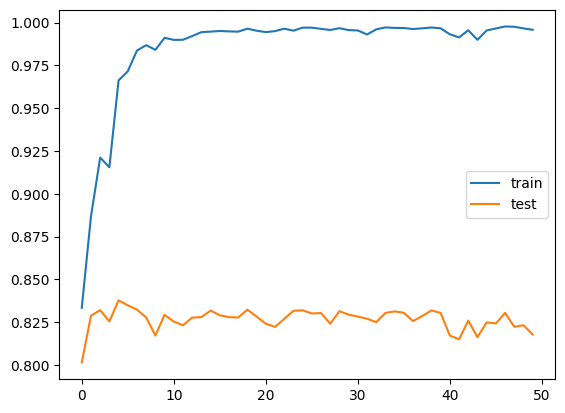

In [12]:
#[MY CODE] train과 test data에 대한 model의 정확도 plot
plot_acc(train_accs_list, test_accs_list, label1='train', label2='test')